## Feed-forward neural networks to predict pEC50
### In this excercise, I have applied the deep learning technique of 'Feed-forward neural networks' to predict pEC50.
### I used the previously create dopamine-receptor dataset. This project can be considered an extension of a previous project where I employed machine learning for this metric's prediction. 

#### In the previous exercise, I was able to pEC50 with the mean absolute error of 0.6, matching industry benchmarks. More details can be found on [here](https://sites.google.com/view/bhawakshi-punia/pec50-prediction?authuser=0).

#### This excercise may serve as a comparison task between ML and DL techniques.

### **Plan of Action:**
#### 1. Reading the dataset. 
#### 2. Exploratory data analysis (EDA)
#### 3. Developing Feed-forward neural networks using **TensorFlow**
#### 4. Ranomised search using `keras_tuner`

In [1]:
# necessary imports 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 

%matplotlib inline 

### 1. The dataset.

In [2]:
df = pd.read_csv('dopamine_pEC50.csv')
df.head()

,Assay Type,Target Name,pEC50,MW,LogP,H_Donors,H_Acceptors,TPSA,Ring_Count,Rotatable_Bonds
0,F,Dopamine D1 receptor,6.625252,315.369,2.2902,3.0,5.0,84.94,3.0,4.0
1,F,Dopamine D1 receptor,6.847712,223.272,1.4489,3.0,4.0,75.71,2.0,2.0
2,F,Dopamine D1 receptor,7.866461,279.380,3.0093,3.0,4.0,75.71,2.0,6.0
3,F,Dopamine D1 receptor,7.903090,315.413,2.8833,3.0,4.0,61.72,3.0,4.0
4,F,Dopamine D1 receptor,7.463442,285.343,2.2816,3.0,4.0,75.71,3.0,3.0


In our previous project, where we predicted pEC50 using machine learning techniques, we modified our dataset as follows:
1. Renaming of the target name columns to shorter names.
2. Removal of rows with pEC50 = 4.0 and 5.0 exactly, since they were inequalities indicating some threshold values of the binding affinity. They were not the actual values.

Note that this dataset has molecular descriptors extracted from the individual molecules' SMILES strings, using RDKit. Consequently, the SMILES column was dropped in this dataset. 

Let's modify our dataset accordingly.

In [3]:
# Renaming Target Name column values to shorter names. 
df['Target Name'] = df['Target Name'].replace({'Dopamine D1 receptor':'D1','Dopamine D2 receptor':'D2',
                                              'Dopamine D3 receptor':'D3','Dopamine D4 receptor':'D4', 'Dopamine D5 receptor':'D5'})

# Removing rows with pEC50 = 4.0 and 5.0 exactly
df = df[(df['pEC50']!=5.0) & (df['pEC50']!=4.0)]
df = df.reset_index().drop('index',axis=1)

df.head()

,Assay Type,Target Name,pEC50,MW,LogP,H_Donors,H_Acceptors,TPSA,Ring_Count,Rotatable_Bonds
0,F,D1,6.625252,315.369,2.2902,3.0,5.0,84.94,3.0,4.0
1,F,D1,6.847712,223.272,1.4489,3.0,4.0,75.71,2.0,2.0
2,F,D1,7.866461,279.380,3.0093,3.0,4.0,75.71,2.0,6.0
3,F,D1,7.903090,315.413,2.8833,3.0,4.0,61.72,3.0,4.0
4,F,D1,7.463442,285.343,2.2816,3.0,4.0,75.71,3.0,3.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2860 entries, 0 to 2859
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Assay Type       2860 non-null   object 
 1   Target Name      2860 non-null   object 
 2   pEC50            2860 non-null   float64
 3   MW               2860 non-null   float64
 4   LogP             2860 non-null   float64
 5   H_Donors         2860 non-null   float64
 6   H_Acceptors      2860 non-null   float64
 7   TPSA             2860 non-null   float64
 8   Ring_Count       2860 non-null   float64
 9   Rotatable_Bonds  2860 non-null   float64
dtypes: float64(8), object(2)
memory usage: 223.6+ KB


There are no missing values.

Although we have performed EDA in our previous project, let's do some extra EDA and try to observe anything interesting. If not, we will move onto deep learning.

### 2. Exploratory Data Analysis (EDA)

In [5]:
# from a correlation analysis, let us identify the features that contribute to the pEC50 value the most.

corrs = df.corr(numeric_only=True)['pEC50'].sort_values(ascending=True)[:-1]
corrs

TPSA              -0.088466
H_Acceptors       -0.047403
MW                -0.025735
Rotatable_Bonds    0.022540
Ring_Count         0.035838
LogP               0.037246
H_Donors           0.045938
Name: pEC50, dtype: float64

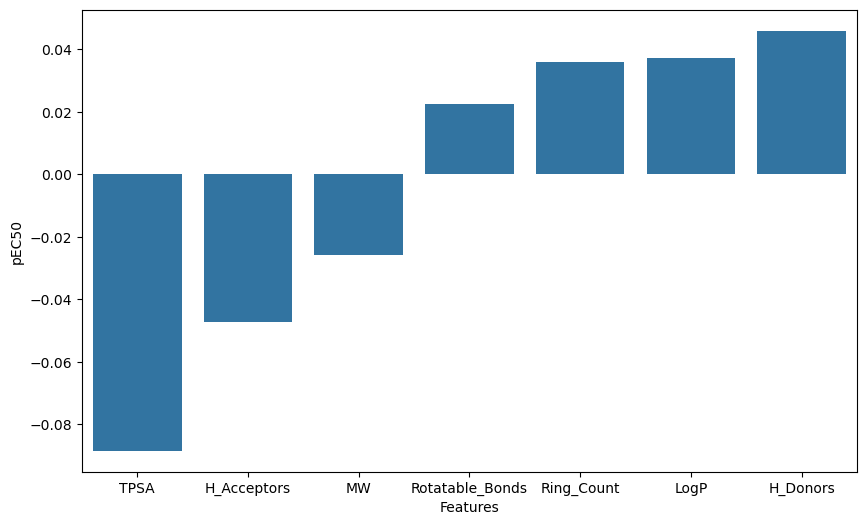

In [10]:
plt.figure(figsize=(10,6))
sns.barplot(data=corrs)
plt.xlabel("Features")
plt.show()

Well, it is observed that the correlations are not that strong but maybe there are some hidden features that our machine learning and deep learning models may recognise. 

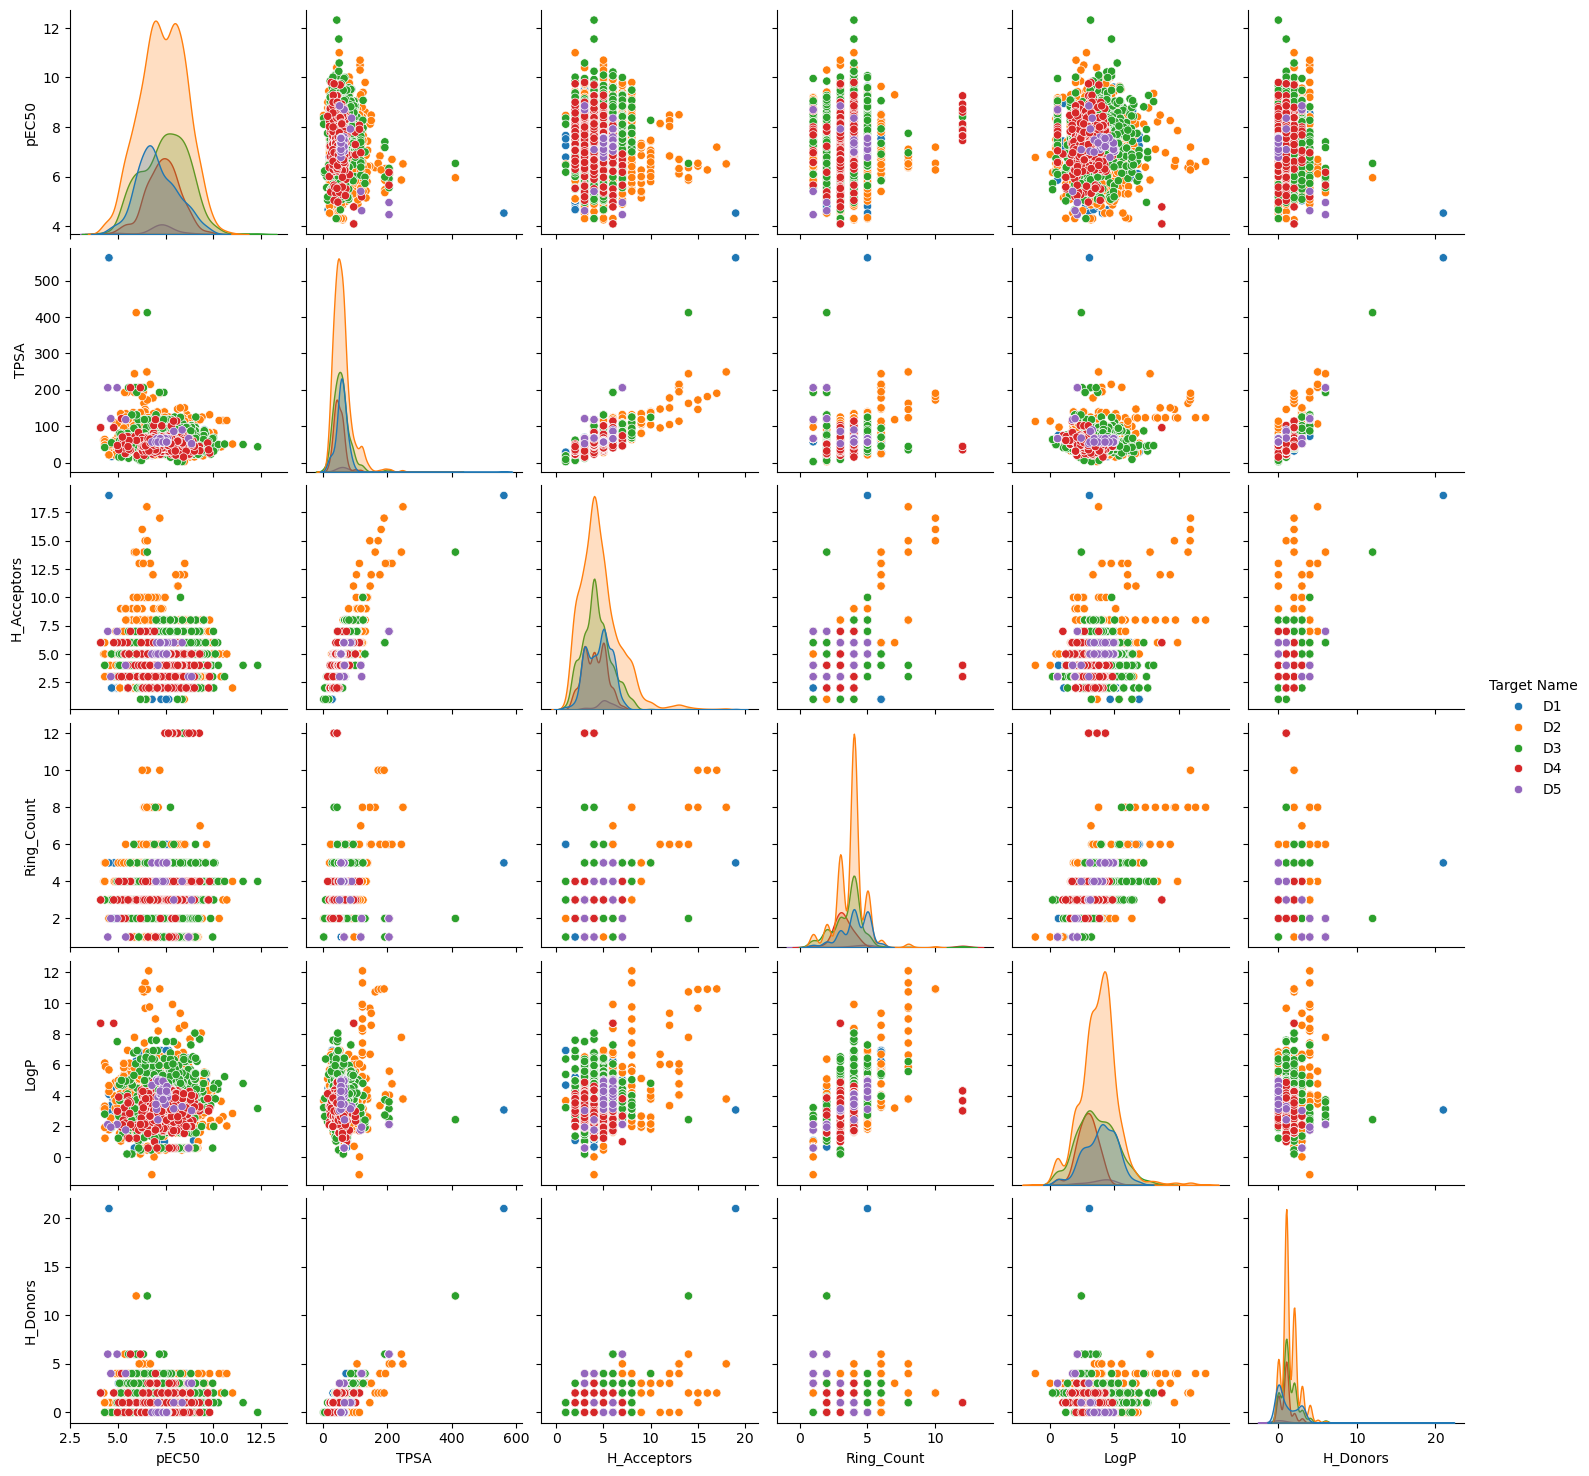

In [14]:
# a pairplot for our visualisation 
# i am not considering the features MW and Rotatable_Bonds since their correlation was not that strong 

sns.pairplot(data=df[['pEC50', 'Target Name', 'TPSA', 'H_Acceptors', 'Ring_Count', 'LogP', 'H_Donors']],hue='Target Name')
plt.show()

I can see 3 outliers! 

1. A single data of D1-type receptor with pEC50 ~ 4.5, H_Donors>20 (the blue point).
2. A D2- and D3- type target receptor molecule entry which has H_Donors>10. I think their H_Donors value is same.

Let's remove them.

In [17]:
# removing the outliers 

df = df[df['H_Donors']<10]

In [19]:
# reindexing our dataframe 

df = df.reset_index().drop('index', axis=1)
df 

,Assay Type,Target Name,pEC50,MW,LogP,H_Donors,H_Acceptors,TPSA,Ring_Count,Rotatable_Bonds
0,F,D1,6.625252,315.369,2.29020,3.0,5.0,84.94,3.0,4.0
1,F,D1,6.847712,223.272,1.44890,3.0,4.0,75.71,2.0,2.0
2,F,D1,7.866461,279.380,3.00930,3.0,4.0,75.71,2.0,6.0
3,F,D1,7.903090,315.413,2.88330,3.0,4.0,61.72,3.0,4.0
4,F,D1,7.463442,285.343,2.28160,3.0,4.0,75.71,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...
2852,B,D5,7.540608,385.467,4.28530,0.0,5.0,56.89,5.0,2.0
2853,B,D5,5.400000,326.470,1.77042,4.0,4.0,118.42,1.0,8.0
2854,B,D5,4.460000,541.475,2.12360,6.0,7.0,205.91,1.0,8.0
2855,B,D5,4.950000,561.465,2.13360,6.0,7.0,205.91,2.0,6.0


Let's also visualise a scatterplot comparison according to D1- and D2- like receptor patterns.

In [32]:
# scatter plots 

def scatter_plot_d1_d2(df, feat): 
    
    #define plotting region (1 row, 2 columns)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6),dpi=300)
    
    # D1-like
    sns.scatterplot(data=df[(df['Target Name']=='D1') | (df['Target Name']=='D5')], 
                                x=feat, y='pEC50', linewidth=0, alpha=0.5, hue='Target Name', ax=axes[0]);
    sns.move_legend(
        axes[0], "lower center",
        bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
        )
    
    # D2-like
    sns.scatterplot(data=df[(df['Target Name']=='D2') | (df['Target Name']=='D3') | (df['Target Name']=='D4')], 
                x=feat, y='pEC50', linewidth=0, alpha=0.5, hue='Target Name', ax=axes[1]);
    sns.move_legend(
        axes[1], "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
        )
        
    axes[0].tick_params(labelrotation=90)
    axes[1].tick_params(labelrotation=90)
    
    plt.tight_layout()
    plt.show()

In [34]:
# box plot for integral-valued features

def box_plot_d1_d2(df, feat): 
    
    #define plotting region (1 row, 2 columns)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6),dpi=300)
    
    # D1-like
    sns.boxplot(data=df[(df['Target Name']=='D1') | (df['Target Name']=='D5')], 
                                x=feat, y='pEC50', hue='Target Name', ax=axes[0]);
    sns.move_legend(
        axes[0], "lower center",
        bbox_to_anchor=(.5, 1), ncol=2, title=None, frameon=False,
        )
    
    # D2-like
    sns.boxplot(data=df[(df['Target Name']=='D2') | (df['Target Name']=='D3') | (df['Target Name']=='D4')], 
                x=feat, y='pEC50', hue='Target Name', ax=axes[1]);
    sns.move_legend(
        axes[1], "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
        )
        
    axes[0].tick_params(labelrotation=90)
    axes[1].tick_params(labelrotation=90)
    
    plt.tight_layout()
    plt.show()

In [30]:
df.columns

Index(['Assay Type', 'Target Name', 'pEC50', 'MW', 'LogP', 'H_Donors',
       'H_Acceptors', 'TPSA', 'Ring_Count', 'Rotatable_Bonds'],
      dtype='object')

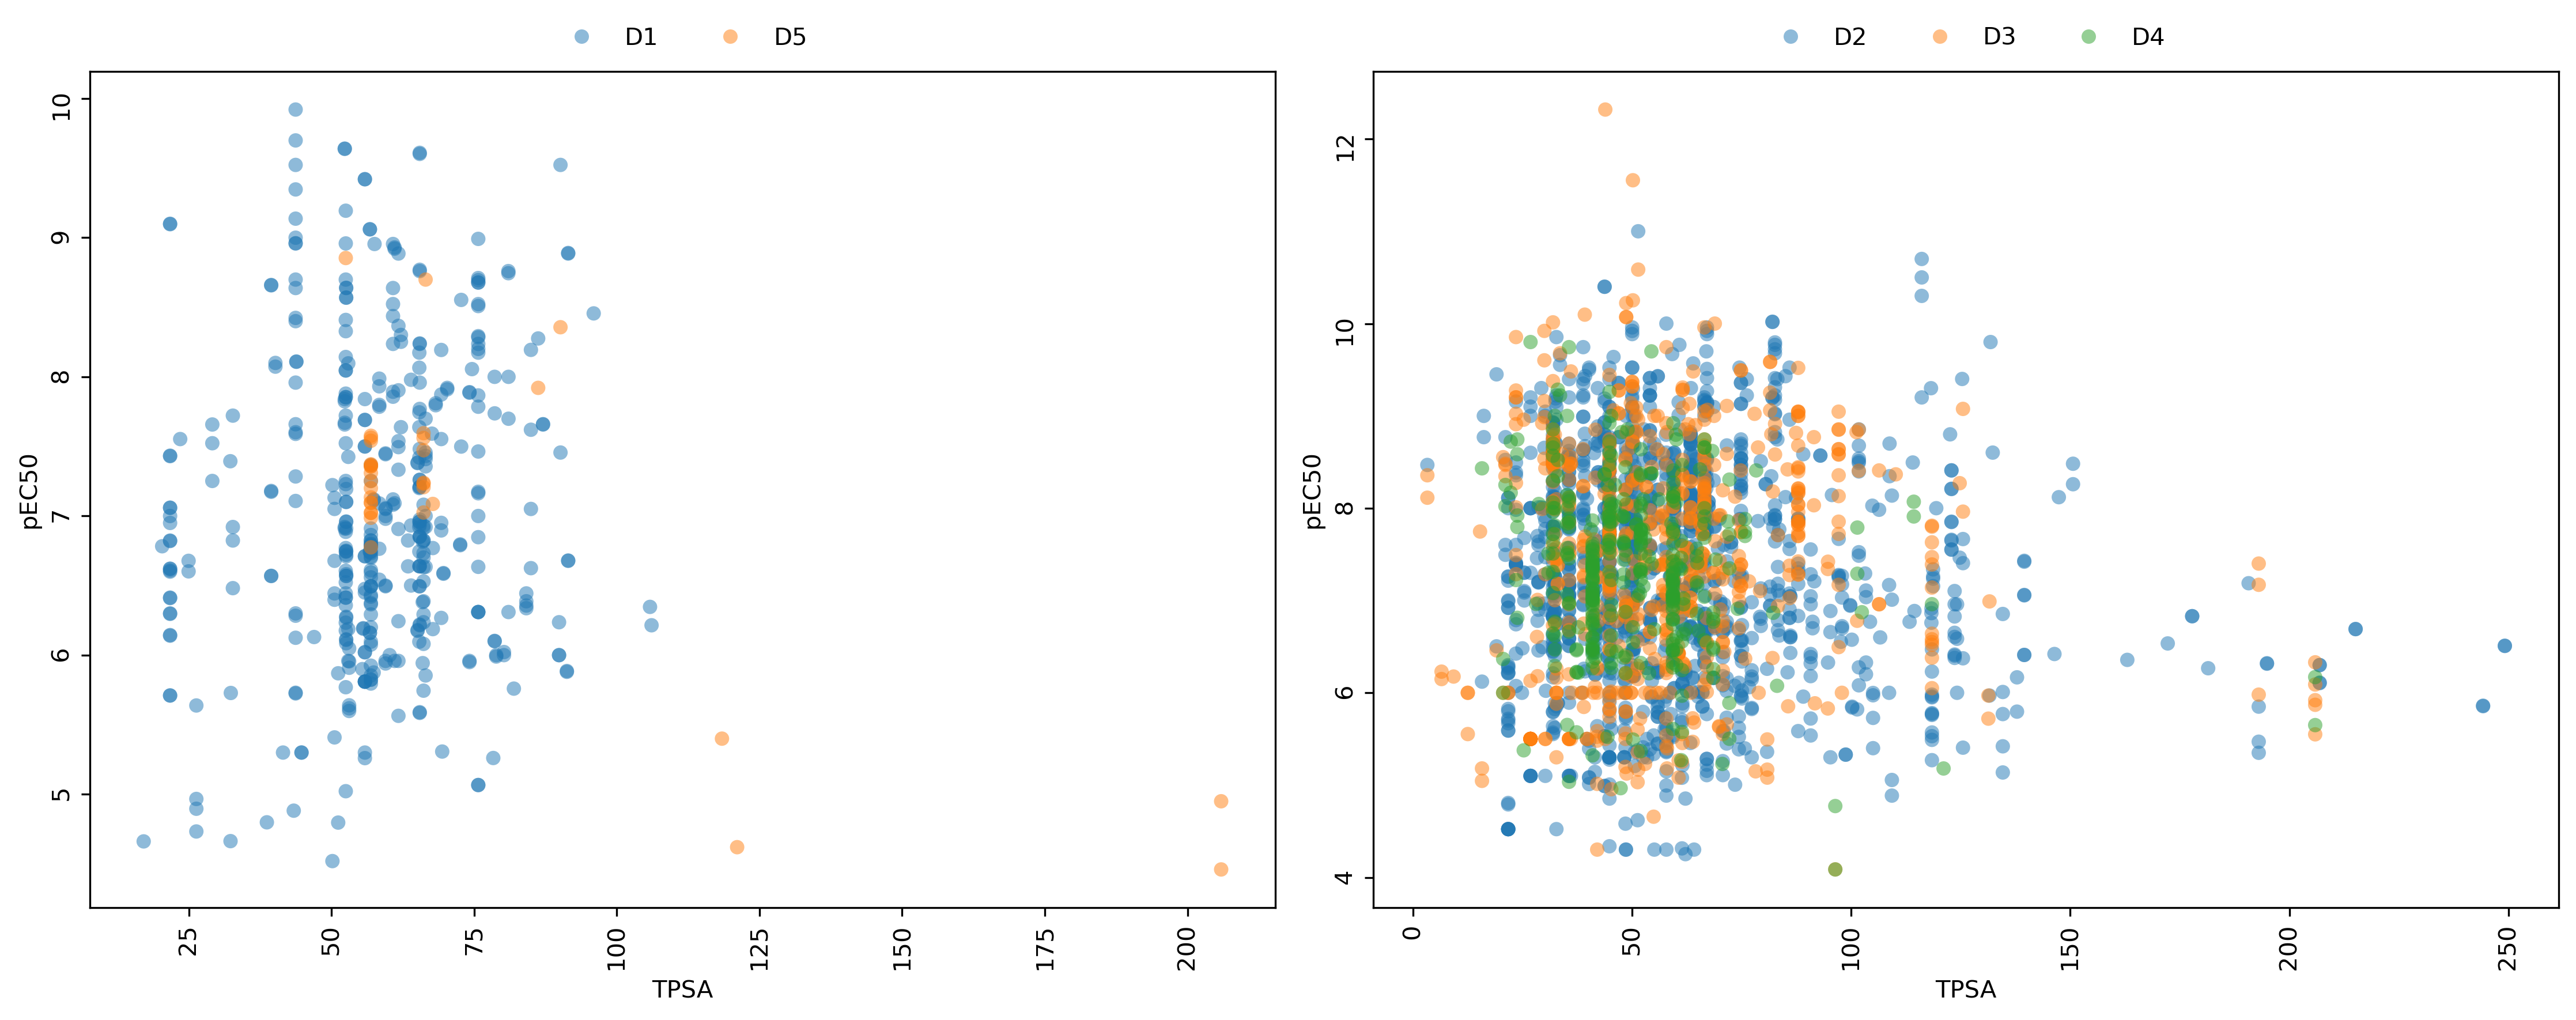

In [42]:
scatter_plot_d1_d2(df, 'TPSA')

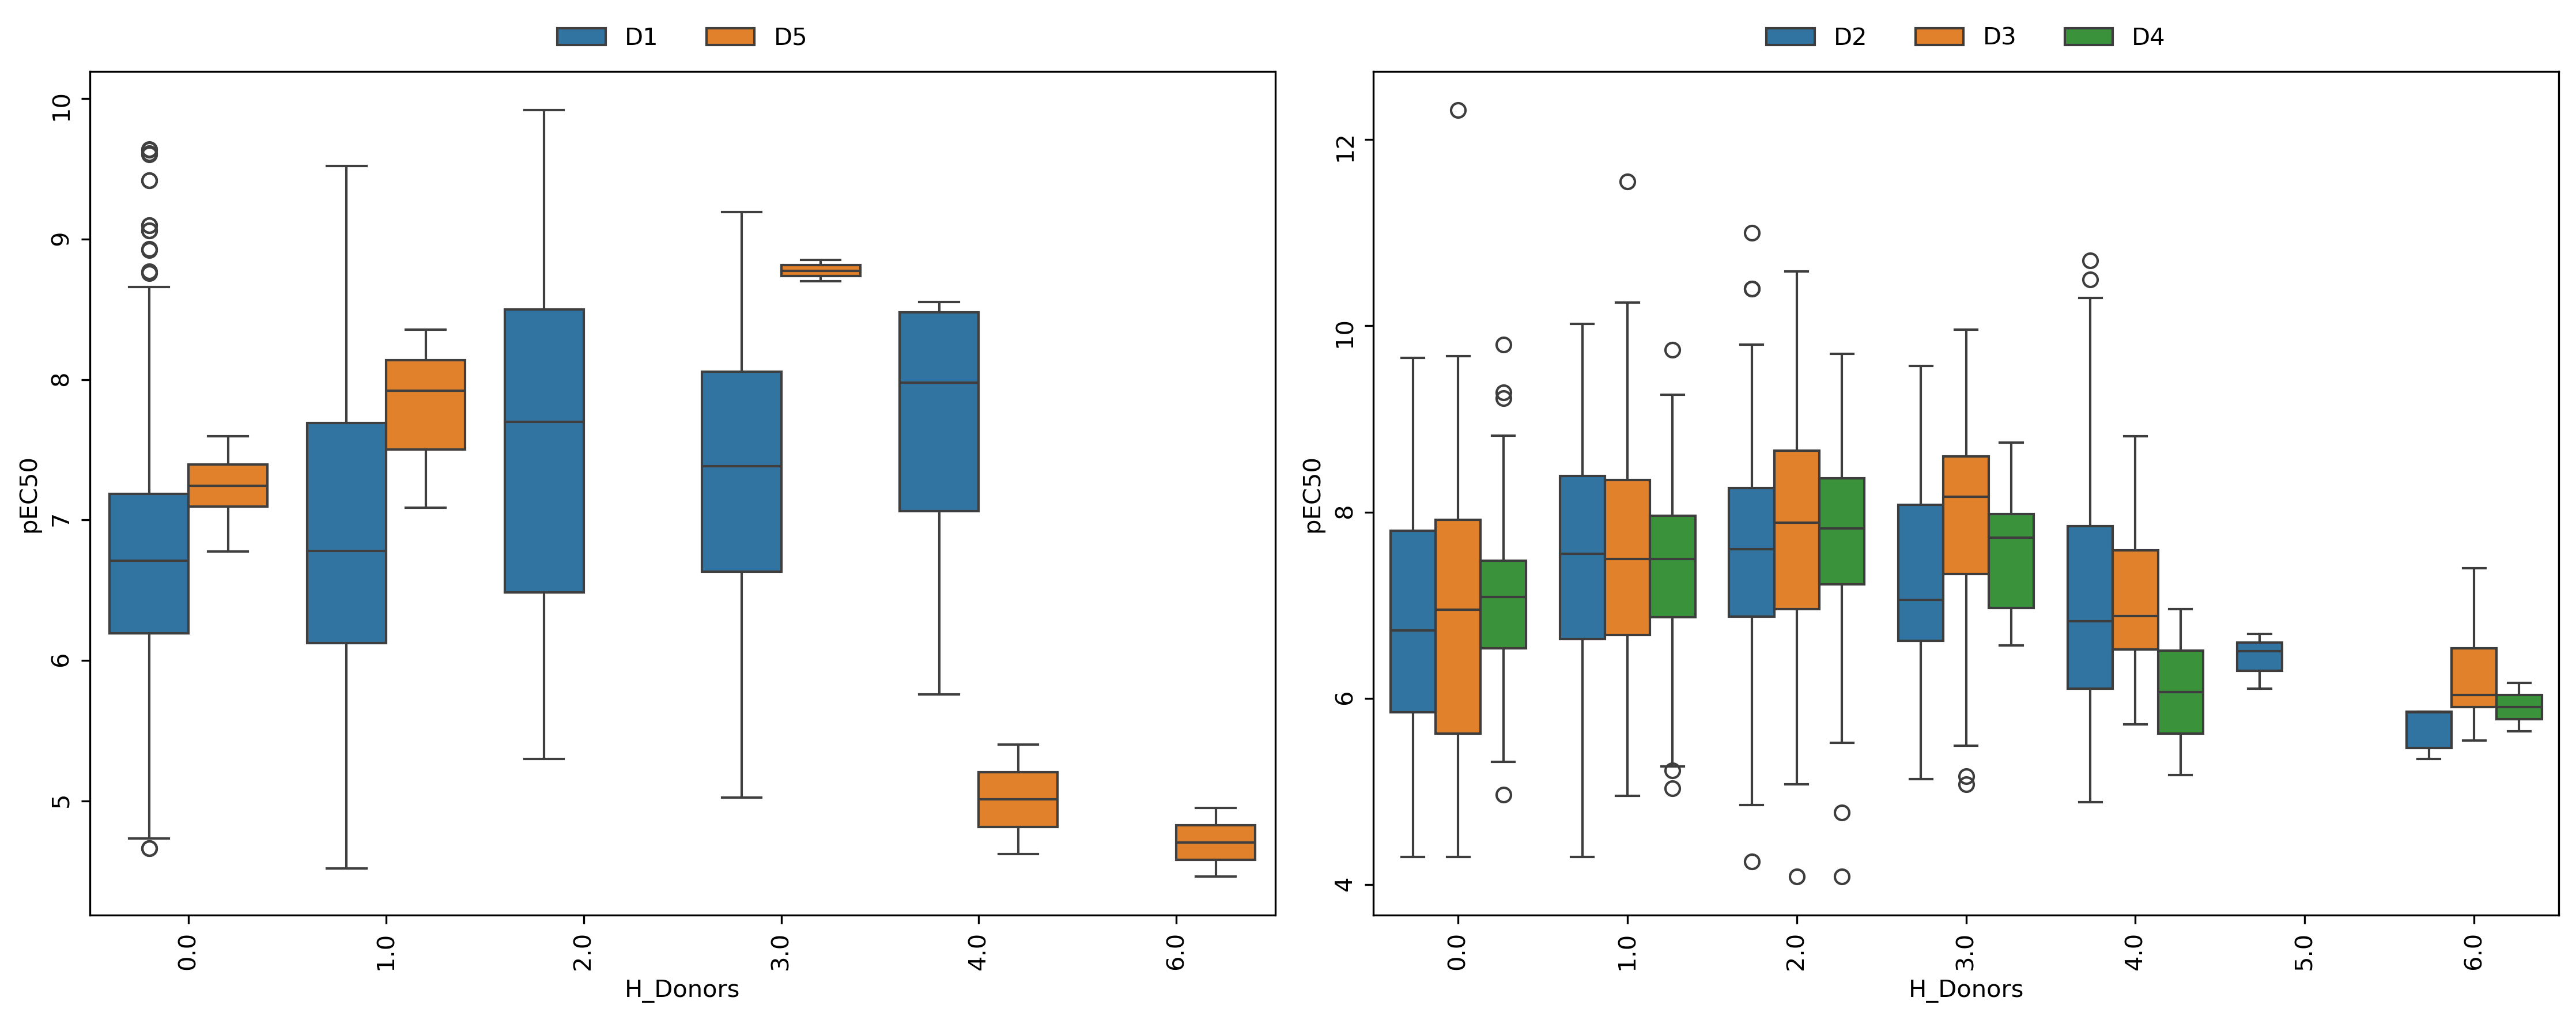

In [41]:
box_plot_d1_d2(df, 'H_Donors')

While D1 like receptors show and increase in pEC50 as number of H_Donors increase (except for few D5-receptors with H_Donors>=4), D2-like receptors show a non-monotonic behaviour.

Okay, it is now time to move onto our Deep Learning for the pEC50 prediction. 

## 3. Deep Learning - creating feedforward neural networks

In [1]:
# necessary imports 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd 

%matplotlib inline 

In [2]:
# reading the dataset 
df = pd.read_csv('dopamine_pEC50.csv')

# Renaming Target Name column values to shorter names. 
df['Target Name'] = df['Target Name'].replace({'Dopamine D1 receptor':'D1','Dopamine D2 receptor':'D2',
                                              'Dopamine D3 receptor':'D3','Dopamine D4 receptor':'D4', 'Dopamine D5 receptor':'D5'})

# Removing rows with pEC50 = 4.0 and 5.0 exactly
df = df[(df['pEC50']!=5.0) & (df['pEC50']!=4.0)]
df = df.reset_index().drop('index',axis=1)

# removing the outliers 
df = df[df['H_Donors']<10]
df = df.reset_index().drop('index',axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2857 entries, 0 to 2856
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Assay Type       2857 non-null   object 
 1   Target Name      2857 non-null   object 
 2   pEC50            2857 non-null   float64
 3   MW               2857 non-null   float64
 4   LogP             2857 non-null   float64
 5   H_Donors         2857 non-null   float64
 6   H_Acceptors      2857 non-null   float64
 7   TPSA             2857 non-null   float64
 8   Ring_Count       2857 non-null   float64
 9   Rotatable_Bonds  2857 non-null   float64
dtypes: float64(8), object(2)
memory usage: 223.3+ KB


In [7]:
df.describe()

,pEC50,MW,LogP,H_Donors,H_Acceptors,TPSA,Ring_Count,Rotatable_Bonds
count,2857.000000,2857.000000,2857.000000,2857.000000,2857.000000,2857.000000,2857.000000,2857.000000
mean,7.325761,385.022001,3.673156,1.302415,4.483374,58.650200,3.742387,6.137907
std,1.147421,109.696941,1.412859,1.082182,1.812795,27.137995,1.205496,4.170292
min,4.086186,138.122000,-1.129200,0.000000,1.000000,3.240000,1.000000,0.000000
25%,6.519993,326.415000,2.783500,1.000000,3.000000,43.700000,3.000000,3.000000
50%,7.309804,392.499000,3.686000,1.000000,4.000000,55.040000,4.000000,6.000000
75%,8.150028,436.556000,4.493980,2.000000,5.000000,66.480000,4.000000,8.000000
max,12.318759,1293.665000,12.094200,6.000000,18.000000,249.200000,12.000000,44.000000


In [3]:
# X, y split of our dataset
X = df.drop('pEC50', axis=1)
y = df['pEC50']

In [4]:
# train, validation and test split now 

from sklearn.model_selection import train_test_split

# performing the train, validation and hold-out dataset split now (80/10/10) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_val, X_hold, y_val, y_hold = train_test_split(X_test, y_test, test_size=0.5, random_state=101)


In [5]:
# creating X_train+X_val and y_train+y_val sets to perform a cross-validated analysis as well 

X_prac = pd.concat([X_train,X_val]) 
X_prac_reset = X_prac.reset_index().drop('index',axis=1)
y_prac = pd.concat([y_train,y_val])
y_prac_reset = y_prac.reset_index().drop('index',axis=1)

In [6]:
X_train.shape, X_val.shape, X_prac.shape

((2285, 9), (286, 9), (2571, 9))

In [7]:
# since we don't have a fixed range of values for each column, 
# it is better to choose standard_scaler instead for scaling our numerical features
# the two categorical columns will be one-hot encoded.

# setting up the preprocessor

from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

cat_feat = X.select_dtypes(include='object').columns.tolist()
cat_transformer = OneHotEncoder().set_output(transform="default")

num_feat = X.select_dtypes(include=np.number).columns.tolist()
num_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[ ("cat",cat_transformer,cat_feat),
                                               ("num",num_transformer,num_feat)])

In [8]:
# storing the dataframes of transformed X features
transformed_X_train = preprocessor.fit_transform(X_train)
transformed_X_train_df = pd.DataFrame(transformed_X_train,columns=preprocessor.get_feature_names_out())
transformed_X_val_df = pd.DataFrame(preprocessor.transform(X_val),columns=preprocessor.get_feature_names_out())
transformed_X_hold_df = pd.DataFrame(preprocessor.transform(X_hold),columns=preprocessor.get_feature_names_out())

#### Building our NN model now

In [9]:
# necessary imports 

import tensorflow as tf
import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [10]:
# setting up early stopping callback 
# i will monitor our target scoring metric - MAE

early_stop = EarlyStopping(monitor='val_mae', mode='min', verbose=1, patience=10)

In [11]:
print(transformed_X_train_df.columns) 
print(len(transformed_X_train_df.columns))

Index(['cat__Assay Type_A', 'cat__Assay Type_B', 'cat__Assay Type_F',
       'cat__Target Name_D1', 'cat__Target Name_D2', 'cat__Target Name_D3',
       'cat__Target Name_D4', 'cat__Target Name_D5', 'num__MW', 'num__LogP',
       'num__H_Donors', 'num__H_Acceptors', 'num__TPSA', 'num__Ring_Count',
       'num__Rotatable_Bonds'],
      dtype='object')
15


In [12]:
# building the model
# input layer --> 16 --> 8 --> 4 --> 1 (output layer)

# input shape 
i_s = len(transformed_X_train_df.columns)

def create_model():
    tf.keras.backend.clear_session()
    tf.random.set_seed(101)
    np.random.seed(101)
    
    keras.utils.set_random_seed(101)
    
    model = Sequential()
    
    model.add(keras.Input(shape=(i_s,)))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=8, activation='relu'))
    model.add(Dense(units=4, activation='relu'))
    
    model.add(Dense(units=1)) # output layer
    
    model.compile(optimizer='adam', loss='mse', metrics = ['mae'])

    return model


In [13]:
model = create_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
transformed_X_train_df.values.shape

(2285, 15)

In [23]:
# fitting our model without early stopping

np.random.seed(101)
model_nes = create_model()
model_nes.fit(x=transformed_X_train_df.values, y=y_train, validation_data=(transformed_X_val_df.values, y_val),
          batch_size = 32, epochs = 500)

Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49.8106 - mae: 6.9310 - val_loss: 35.5306 - val_mae: 5.7318
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step - loss: 31.5264 - mae: 5.3519 - val_loss: 14.3123 - val_mae: 3.3884
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 10.7729 - mae: 2.8598 - val_loss: 4.6385 - val_mae: 1.6991
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 4.1564 - mae: 1.5742 - val_loss: 2.8894 - val_mae: 1.3381
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 2.8244 - mae: 1.3127 - val_loss: 2.3112 - val_mae: 1.1954
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 612us/step - loss: 2.2236 - mae: 1.1882 - val_loss: 2.0252 - val_mae: 1.1331
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 1.8710 - mae: 1.1054 - val_loss: 1.8548 - val_mae: 1.0915
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 1.6542 - mae: 1.0451 - val_loss: 1.7338 - val_mae: 1.0603
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 632

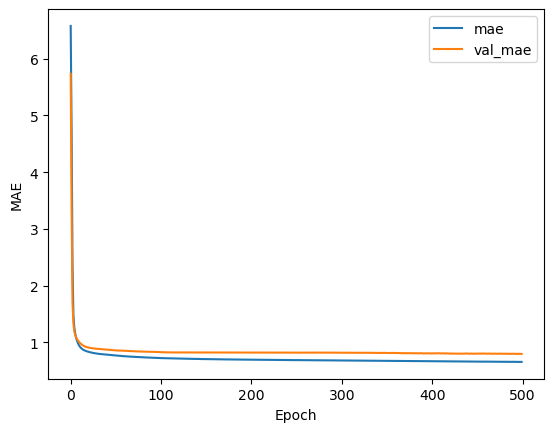

In [24]:
# plotting our losses - MAE

loss_nes_df = pd.DataFrame(model_nes.history.history)
loss_nes_df[['mae','val_mae']].plot();
plt.xlabel("Epoch"); 
plt.ylabel("MAE");
plt.show()

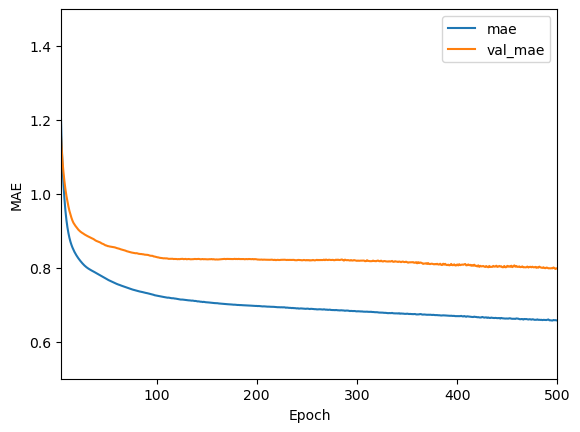

In [25]:
# plotting our losses - MAE
# a zoomed-in version 

loss_nes_df = pd.DataFrame(model_nes.history.history)
loss_nes_df[['mae','val_mae']].plot();
plt.xlabel("Epoch"); 
plt.ylabel("MAE");
plt.xlim(5,500);
plt.ylim(0.5,1.5);
plt.show()

In [15]:
# fitting our model without early stopping
np.random.seed(101)
model_es = create_model()
model_es.fit(x=transformed_X_train_df.values, y=y_train, validation_data=(transformed_X_val_df.values, y_val),
          batch_size = 32, epochs = 500, callbacks = [early_stop])

Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49.8106 - mae: 6.9310 - val_loss: 35.5306 - val_mae: 5.7318
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 31.5264 - mae: 5.3519 - val_loss: 14.3123 - val_mae: 3.3884
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 10.7729 - mae: 2.8598 - val_loss: 4.6385 - val_mae: 1.6991
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - loss: 4.1564 - mae: 1.5742 - val_loss: 2.8894 - val_mae: 1.3381
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 2.8244 - mae: 1.3127 - val_loss: 2.3112 - val_mae: 1.1954
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 613us/step - loss: 2.2236 - mae: 1.1882 - val_loss: 2.0252 - val_mae: 1.1331
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 1.8710 - mae: 1.1054 - val_loss: 1.8548 - val_mae: 1.0915
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 1.6542 - mae: 1.0451 - val_loss: 1.7338 - val_mae: 1.0603
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 628

Stopped early after n_epochs = 172.

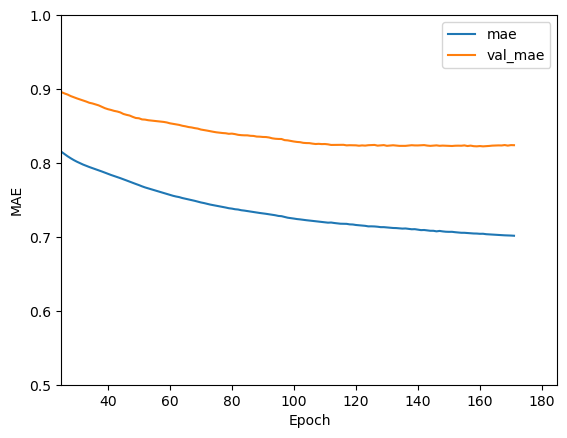

In [16]:
# plotting our losses - MAE

loss_es_df = pd.DataFrame(model_es.history.history)
loss_es_df[['mae','val_mae']].plot();
plt.xlabel("Epoch"); 
plt.ylabel("MAE");
plt.xlim(25,185);
plt.ylim(0.5,1);
plt.show()

With early-stopping callback, the number of epochs required are = 169. 

#### Let's calculate other metrics - RMSE and R^2.

In [17]:
# a function to define metric scores

from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

def metric_scores(y_preds_train, y_preds_val,y_train,y_val):

    mae_t = mean_absolute_error(y_train,y_preds_train)
    rmse_t = np.sqrt(mean_squared_error(y_train,y_preds_train))
    r2_t = r2_score(y_train,y_preds_train)

    mae_v = mean_absolute_error(y_val,y_preds_val)
    rmse_v = np.sqrt(mean_squared_error(y_val,y_preds_val))
    r2_v = r2_score(y_val,y_preds_val)

    return [mae_t,rmse_t,r2_t,mae_v,rmse_v,r2_v]
    

In [84]:
# generating y_predictions for training and test set for getting my scores with the epochs=172 (obtained from early_stopping)

model_es = create_model()
model_es.fit(x=transformed_X_train_df.values, y=y_train, validation_data=(transformed_X_val_df.values, y_val),
          batch_size = 32, epochs = 172, verbose=0)

y_preds_train = model_es.predict(transformed_X_train_df.values)
y_preds_val = model_es.predict(transformed_X_val_df.values)

scores = {}
scores[f'Model_ES'] = metric_scores(y_preds_train, y_preds_val,y_train,y_val)

scores_df = pd.DataFrame(data=scores.values(), index=scores.keys(),columns=["Train MAE","Train RMSE","Train R-squared",
                                                                                "Validation MAE","Validation RMSE","Validation R-squared"])
scores_df.index.name = 'Models'

scores_df

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step


,Train MAE,Train RMSE,Train R-squared,Validation MAE,Validation RMSE,Validation R-squared
Models,,,,,,
Model_ES,0.696508,0.90167,0.372005,0.824031,1.019797,0.276543


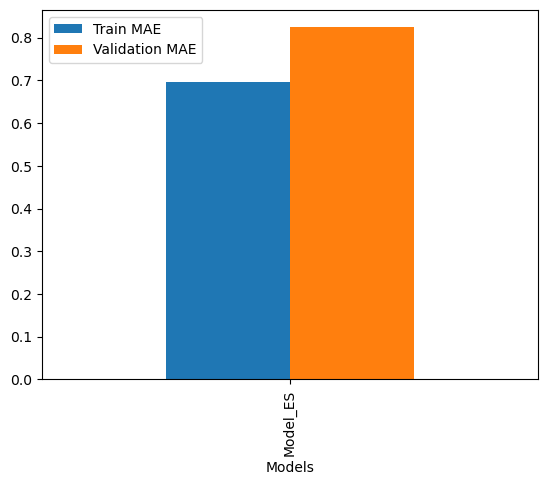

In [28]:
scores_df[['Train MAE','Validation MAE']].plot(kind='bar'); 
plt.show()

Well, it is good to see that the overfitting is significantly reduced in our deep learning approach compared to the machine learning techniques we applied in our [previous project](https://sites.google.com/view/bhawakshi-punia/pec50-prediction?authuser=0).

In [85]:
y_preds_val.shape[0]

286

In [29]:
# comparing y_preds with ground truths 

val_preds = pd.Series(y_preds_val.reshape(y_preds_val.shape[0],))
preds_df = pd.DataFrame(y_val.values)
preds_df = pd.concat([preds_df,val_preds],axis=1)
preds_df.columns=['True y_val', 'Preds']

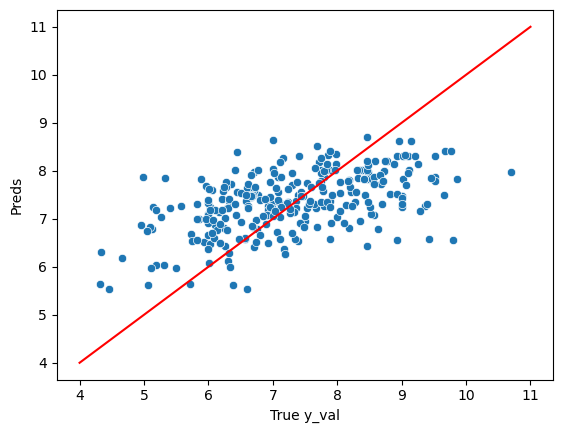

In [30]:
sns.scatterplot(data=preds_df,x='True y_val',y='Preds'); 
plt.plot(np.arange(4,12),np.arange(4,12),'r');
plt.show()

### Altogether, it is good to see that our model is not overfitting on the training set (seen from the bar plot), as we were observing in our previous ML models. 

Let us also evaluate **cross-validation metrics** of our model. Don't forget I will need to use X_prac (train+val) and y_prac (train=val) here.

Steps followed: 
1. Create empty lists to store all metric scores (MAE, RMSE and R^2).
2. A 'for loop' to get train/test split indices using KFold.split() from X_prac.
3. Split X_prac and y_prac to train/tests.
4. Fit-Transform train_x in that loop using the preprocessor and transform the test_x.
5. Call function `create_model()` to create our model.
6. Fit the model using the generated splits: don't forget to use np array values, epochs = 63 (obtained from early stopping), batch_size = 32, verbose=0.
7. Get corresponding y-preds for both train and test splits.
8. Evaluate the metric scores using the function and store in the list.
9.  Generate a dataframe and report the final mean values of all scores from them.

#### Cross-validation scores

In [18]:
# performing a cross-validation analysis: 5-fold 

from sklearn.model_selection import KFold 

kf = KFold(n_splits=5, random_state=101, shuffle=True) 

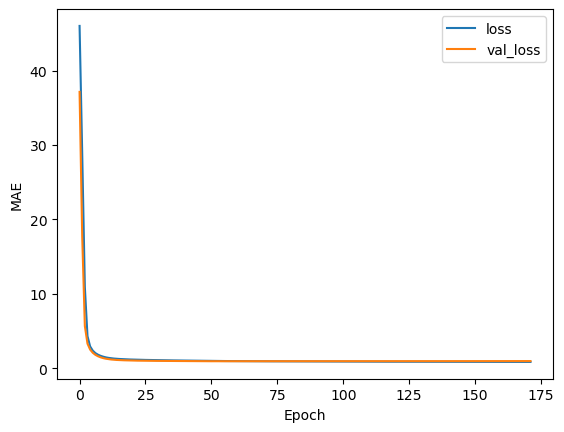

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


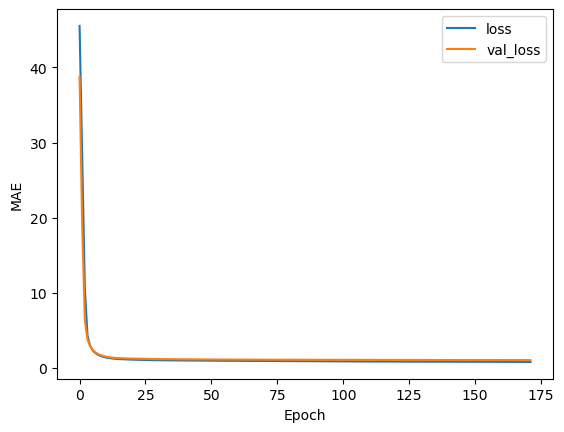

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step


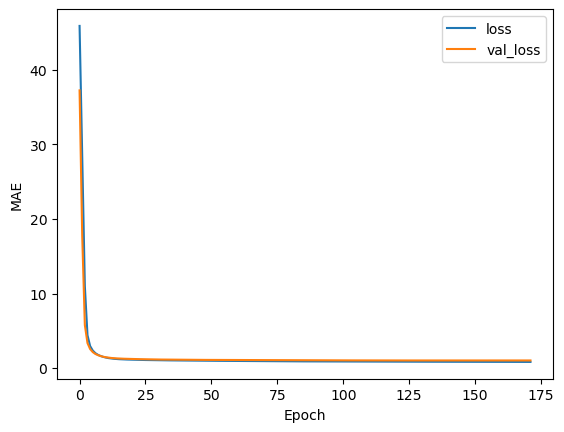

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


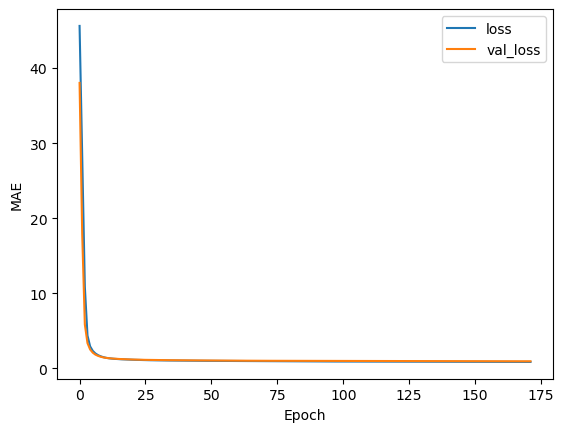

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


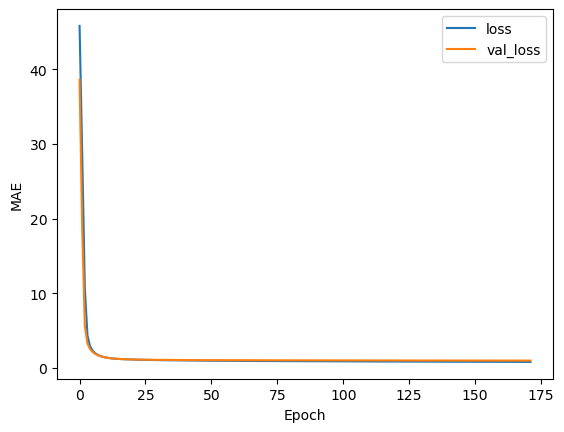

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step


In [32]:
all_scores = []

np.random.seed(101)
for train_index, test_index in list(kf.split(X_prac)):
    # Split the data
    X1_train, X1_test = X_prac_reset.iloc[train_index], X_prac_reset.iloc[test_index]
    y1_train, y1_test = y_prac_reset.iloc[train_index], y_prac_reset.iloc[test_index]

    # transforming the X sets using the preprocessor
    
    X1_train = pd.DataFrame(preprocessor.fit_transform(X1_train),columns=preprocessor.get_feature_names_out())
    X1_test = pd.DataFrame(preprocessor.transform(X1_test),columns=preprocessor.get_feature_names_out())

    # building the model 
    model1 = create_model() 

    # fit the model 
    model1.fit(x=X1_train.values, y=y1_train, validation_data=(X1_test.values, y1_test),
              batch_size = 32, epochs = 172, verbose=0)

    # plotting the losses for better visualisation 
    loss1 = pd.DataFrame(model1.history.history)
    loss1[['loss','val_loss']].plot();
    plt.xlabel("Epoch"); 
    plt.ylabel("MAE");
    plt.show()
    
    #print(model1.history.history)

    # generating y_predictions for training and test set
    y1_preds_train = model1.predict(X1_train.values)
    y1_preds_test = model1.predict(X1_test.values)
    
    all_scores.append(metric_scores(y1_preds_train, y1_preds_test, y1_train, y1_test))

In [33]:
cv_scores = pd.DataFrame(all_scores, columns=["Train MAE","Train RMSE","Train R-squared",
                                    "Validation MAE","Validation RMSE","Validation R-squared"])
cv_scores

,Train MAE,Train RMSE,Train R-squared,Validation MAE,Validation RMSE,Validation R-squared
0,0.701277,0.908981,0.384193,0.778837,0.977341,0.192373
1,0.706329,0.897228,0.379290,0.781374,1.027912,0.223565
2,0.702998,0.904413,0.364059,0.794357,1.013438,0.269931
3,0.711058,0.909244,0.372173,0.769532,0.962859,0.277752
4,0.704602,0.894374,0.389927,0.763829,0.996633,0.241003


In [34]:
cv_scores.describe()

,Train MAE,Train RMSE,Train R-squared,Validation MAE,Validation RMSE,Validation R-squared
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.705253,0.902848,0.377928,0.777586,0.995636,0.240925
std,0.003747,0.006789,0.010131,0.011740,0.026309,0.034844
min,0.701277,0.894374,0.364059,0.763829,0.962859,0.192373
25%,0.702998,0.897228,0.372173,0.769532,0.977341,0.223565
50%,0.704602,0.904413,0.379290,0.778837,0.996633,0.241003
75%,0.706329,0.908981,0.384193,0.781374,1.013438,0.269931
max,0.711058,0.909244,0.389927,0.794357,1.027912,0.277752


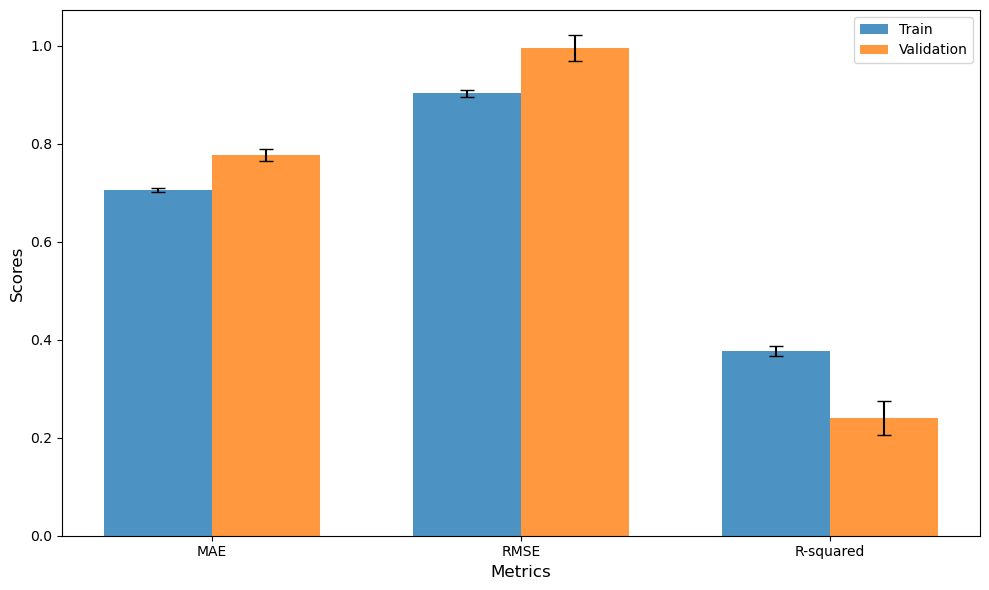

In [35]:
# plotting these scores together 
mean_scores = cv_scores.mean()
std_scores = cv_scores.std()

# Separate train and validation metrics
train_metrics = ['Train MAE', 'Train RMSE', 'Train R-squared']
val_metrics = ['Validation MAE', 'Validation RMSE', 'Validation R-squared']

# Prepare the plot
x_labels = ['MAE', 'RMSE', 'R-squared']
x = np.arange(len(x_labels))
width = 0.35  # Bar width

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train scores
train_means = mean_scores[train_metrics]
train_stds = std_scores[train_metrics]
ax.bar(x - width/2, train_means, width, yerr=train_stds, capsize=5, label='Train', alpha=0.8)

# Plot validation scores
val_means = mean_scores[val_metrics]
val_stds = std_scores[val_metrics]
ax.bar(x + width/2, val_means, width, yerr=val_stds, capsize=5, label='Validation', alpha=0.8)

# Formatting
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
#ax.set_title('Train vs Validation Scores with Error Bars', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

plt.tight_layout()
plt.show()


It's a great result to see our model is not overfitting in the training phase, even though the MAE is slightly higher. 

Validation MAE --> ML: ~0.60 and DL: ~0.82

It indicates that we can try to tune our hyperparameters further to check the possibility of improvement of scores. 

#### **Let's perform a randomised search for optimal hyperparameters using `keras_tuner`.**

### 4. Randomised search CV using `keras_tuner`

The hyperparameter space: 

1) the input layer
2) first hidden layer: n_neruons = (8,32, step=8)
3) possibility of 1-3 additional hidden layers with n_units = (4,16, step=4) and associated dropout layer as well: (0,0.5, step=0.1)
4) during compilation, learning rate of the Adam optimizer = (1e-4, 1e-1)

In [44]:
from tensorflow.keras.layers import Dropout

# input shape 
i_s = len(transformed_X_train_df.columns)

# Defining the hyperparameter space along with the model 
def tuned_model(hp): 

    # setting up random seed to ensure reproducibility 
    tf.keras.backend.clear_session()
    tf.random.set_seed(101)
    np.random.seed(101)

    keras.utils.set_random_seed(101)

    model = Sequential()
    
    # The first layer after the input layer
    # n_units = (8,32, step=8)
    model.add(keras.Input(shape=(i_s,)))
    
    # hidden layers - possibility of 1 to 3 layers 
    # n_units = (4,32, step=4) 
    # a dropout layer as well: (0,0.5, step=0.1) 
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'units_input_{i}', min_value=4, max_value=32, step=4), activation='relu'))
            
    # output layer
    model.add(Dense(units=1))
    
    # Compiling the model
    # learning rate of the Adam optimizer = (1e-4, 1e-1)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, 
                  max_value=1e-1, sampling='log')), loss='mse', metrics=['mae'] )
    
    return model


In [20]:
#!pip install keras_tuner

In [47]:
# performing the random search using keras_tuner now 

import keras_tuner as kt

np.random

tuner = kt.RandomSearch(
    tuned_model,
    objective='val_mae',  # optimize for validation MAE
    max_trials=20,  # number of different combinations to try
    executions_per_trial=1,  # train each model once 
    directory='random_search_dir',
    project_name='pEC50_RS_1'
)

# Early stopping callback, keeping the max_epoch 172 which we got from our basic previous run 
early_stopping = EarlyStopping(monitor='val_mae', patience=10)

# let's perform the search now 
tuner.search(
    transformed_X_train_df.values, y_train,
    validation_data=(transformed_X_val_df.values, y_val),
    epochs=172,  # Upper limit for epochs
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1)


Trial 20 Complete [00h 00m 11s]
val_mae: 0.8225730657577515

Best val_mae So Far: 0.7763708233833313
Total elapsed time: 00h 02m 24s


In [48]:
# the best hyperparameter values 

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'num_layers': 4,
 'units_input_0': 32,
 'learning_rate': 0.027808131048430638,
 'units_input_1': 28,
 'units_input_2': 16,
 'units_input_3': 4}

Now, let us build a new model using this set of optimised hyperparameters.

In [49]:
# building the model afresh so that the results are reproducible 
# input layer --> HL1 (32) --> HL2 (4, dropout=0.1) --> HL3 (12, dropout=0.3) --> HL4(4,0.1) --> Output layer

# input shape 
i_s = len(transformed_X_train_df.columns)

# Defining the hyperparameter space along with the model 
def best_tuned_model(): 

    # setting up random seed to ensure reproducibility 
    tf.keras.backend.clear_session()
    tf.random.set_seed(101)
    np.random.seed(101)
    
    keras.utils.set_random_seed(101)

    model = Sequential()
    
    # The first layer after the input layer, n_units = 32
    model.add(keras.Input(shape=(i_s,)))
    
    # Additional hidden layers 
    model.add(Dense( units=32,activation='relu'))
    #model.add(Dropout(rate=0.2))
    model.add(Dense( units=28,activation='relu'))
    #model.add(Dropout(rate=0.1))
    model.add(Dense( units=16,activation='relu'))
    #model.add(Dropout(rate=0.4))
    model.add(Dense( units=4,activation='relu'))
    #model.add(Dropout(rate=0.3))
    
    # output layer
    model.add(Dense(units=1))
    
    # Compiling the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.027808131048430638), loss='mse', metrics=['mae'] )
    
    return model

In [80]:
np.random.seed(101)
best_model = best_tuned_model()

best_model.fit(
    transformed_X_train_df.values, y_train,
    validation_data=(transformed_X_val_df.values, y_val),
    epochs=172,  # Using the same upper limit for epochs
    batch_size=32,
    callbacks=[early_stopping],  # Early stopping
    verbose=1
)


Epoch 1/172
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16.1476 - mae: 2.9156 - val_loss: 1.4554 - val_mae: 0.9916
Epoch 2/172
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 1.2872 - mae: 0.8924 - val_loss: 1.2821 - val_mae: 0.9231
Epoch 3/172
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 1.3278 - mae: 0.9080 - val_loss: 1.2564 - val_mae: 0.9114
Epoch 4/172
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 1.2851 - mae: 0.8896 - val_loss: 1.2129 - val_mae: 0.8935
Epoch 5/172
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 1.2613 - mae: 0.8787 - val_loss: 1.2235 - val_mae: 0.8922
Epoch 6/172
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 610us/step - loss: 1.2374 - mae: 0.8688 - val_loss: 1.2016 - val_mae: 0.8845
Epoch 7/172
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - loss: 1.2196 - mae: 0.8634 - val_loss: 1.1975 - val_mae: 0.8813
Epoch 8/172
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 1.2117 - mae: 0.8595 - val_loss: 1.1561 - val_mae: 0.8614
Epoch 9/172
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/s

Early-stopping at 58. 

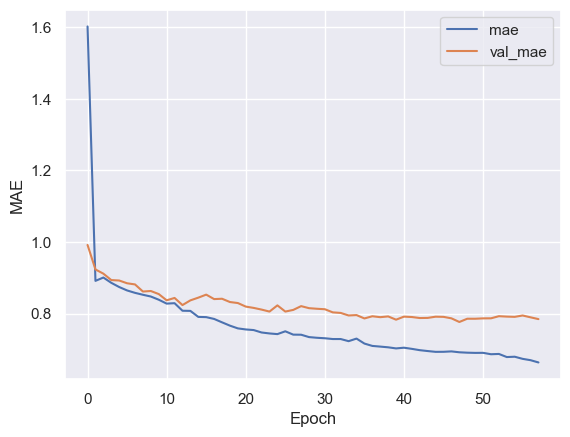

In [81]:
# plotting our losses - MAE

loss_tuned_df = pd.DataFrame(best_model.history.history)
loss_tuned_df[['mae','val_mae']].plot();
plt.xlabel("Epoch"); 
plt.ylabel("MAE");
plt.show()

In [82]:
# generating y_predictions for training and test set for getting my scores with the epochs=52 (obtained from early_stopping)

y_preds_train = best_model.predict(transformed_X_train_df.values)
y_preds_val = best_model.predict(transformed_X_val_df.values)

tuned_scores = {}
tuned_scores[f'RS-Tuned model'] = metric_scores(y_preds_train, y_preds_val,y_train,y_val)

tuned_scores_df = pd.DataFrame(data=tuned_scores.values(), index=tuned_scores.keys(),columns=["Train MAE","Train RMSE","Train R-squared",
                                                                                "Validation MAE","Validation RMSE","Validation R-squared"])
tuned_scores_df.index.name = 'Models'

tuned_scores_df

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step


,Train MAE,Train RMSE,Train R-squared,Validation MAE,Validation RMSE,Validation R-squared
Models,,,,,,
RS-Tuned model,0.652381,0.843605,0.450283,0.784395,1.032461,0.258463


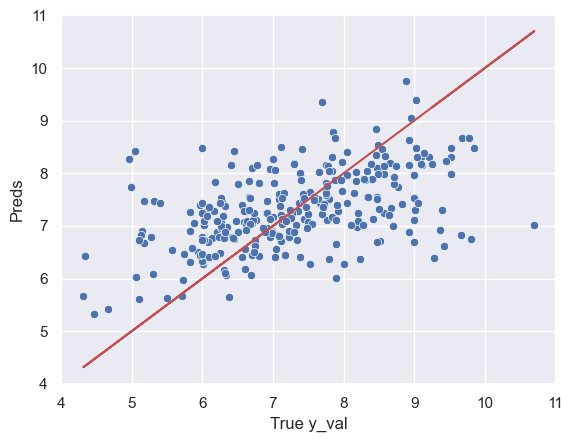

In [83]:
# comparing y_preds with ground truths 

val_preds = pd.Series(y_preds_val.reshape(y_preds_val.shape[0],))
preds_df = pd.DataFrame(y_val.values)
preds_df = pd.concat([preds_df,val_preds],axis=1)
preds_df.columns=['True y_val', 'Preds']

sns.scatterplot(data=preds_df,x='True y_val',y='Preds'); 
#plt.plot(np.arange(4,12),np.arange(4,12),'r');
plt.plot(y_val.values,y_val.values,'r')
plt.show()

In [85]:
# A comparison of the scores of our previous base model and a tuned model 

combined_scores = pd.concat([scores_df,tuned_scores_df])
combined_scores

,Train MAE,Train RMSE,Train R-squared,Validation MAE,Validation RMSE,Validation R-squared
Models,,,,,,
Model_ES,0.696508,0.901670,0.372005,0.824031,1.019797,0.276543
RS-Tuned model,0.652381,0.843605,0.450283,0.784395,1.032461,0.258463


In [1]:
# plotting these scores for better visualisation through a function 

def plot_train_val_scores(df):

    # A df of MAE score 
    df_MAE = df[['Train MAE','Validation MAE']].sort_values("Validation MAE",ascending=True)
    dfm3_MAE = pd.melt(df_MAE.reset_index(), id_vars='Models', var_name="Score type", value_name="Score value")

    # A df of RMSE score 
    df_RMSE = df[['Train RMSE','Validation RMSE']].sort_values("Validation RMSE",ascending=True)
    dfm3_RMSE = pd.melt(df_RMSE.reset_index(), id_vars='Models', var_name="Score type", value_name="Score value")

    # Now dataframe for the R^2 value
    df_R2 = df[['Train R-squared','Validation R-squared']].sort_values("Validation R-squared",ascending=True)
    dfm3_R2 = pd.melt(df_R2.reset_index(), id_vars='Models', var_name="Score type", value_name="Score value")

    #set seaborn plotting aesthetics as default
    sns.set()

    #define plotting region (1 row, 3 columns)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6),dpi=300)

    #create boxplot in each subplot for all scoring metrics together 

    # MAE - dfm3_MAE
    sns.barplot(data=dfm3_MAE,x="Models",y="Score value",hue="Score type", ax=axes[0]);
    sns.move_legend(
    axes[0], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )

    # RMSE - dfm3_RMSE
    sns.barplot(data=dfm3_RMSE,x="Models",y="Score value",hue="Score type", ax=axes[1]);
    sns.move_legend(
    axes[1], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )

    # R^2 - dfm3_R2
    sns.barplot(data=dfm3_R2,x="Models",y="Score value",hue="Score type", ax=axes[2]);
    sns.move_legend(
    axes[2], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )

    axes[0].tick_params(labelrotation=90)
    axes[1].tick_params(labelrotation=90)
    axes[2].tick_params(labelrotation=90)

    plt.tight_layout()
    return plt.show()


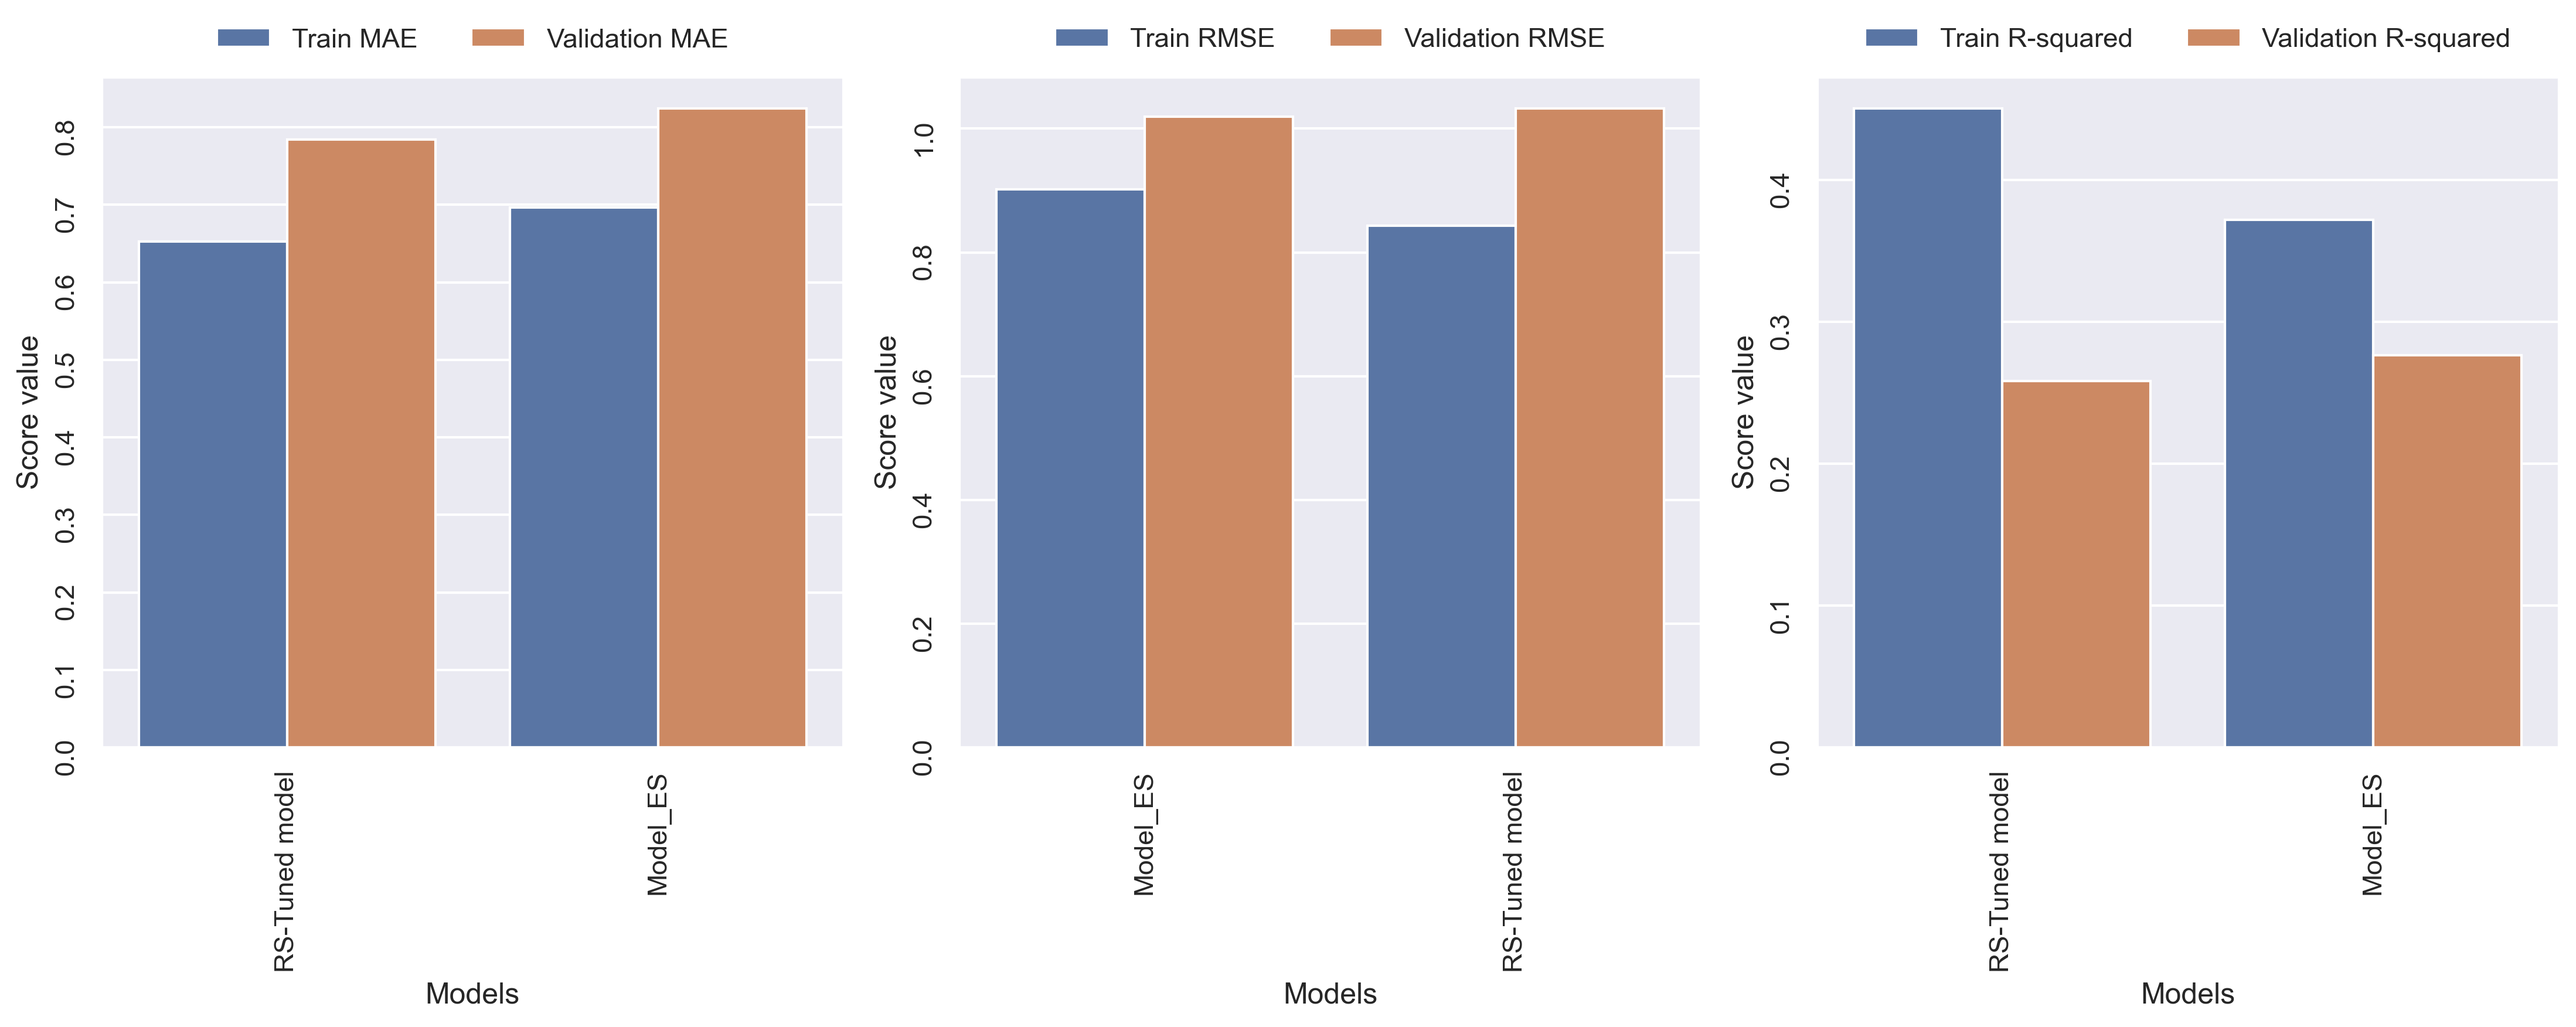

In [58]:
plot_train_val_scores(combined_scores)

It is good to see that our scores have improved by performing a randomised search. An exhaustive grid search must also be performed to see if the scores improve further. 

#### Most importantly, our ANNs are not overfitting on the training set which was a concerning issue in our machine learning project.

Let's also evaluate the cross-validated sccores with this tuned model.

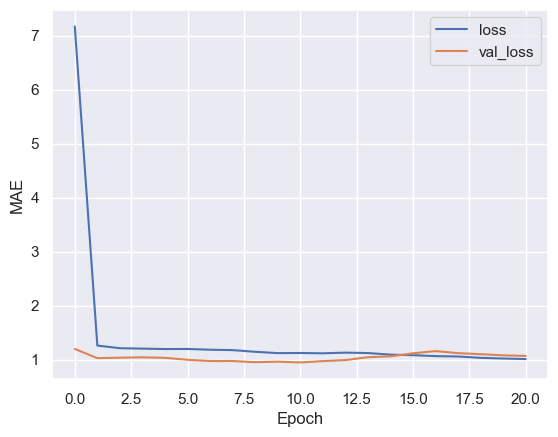

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step


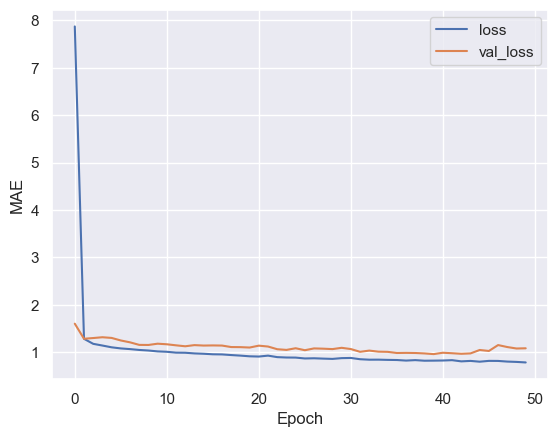

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


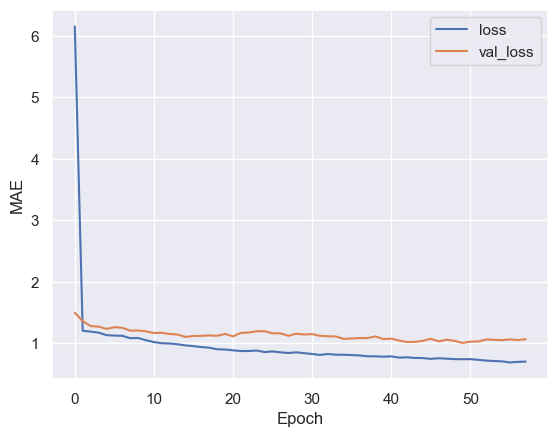

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step


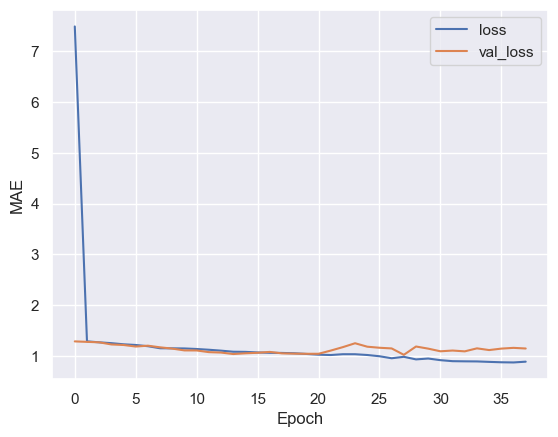

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step


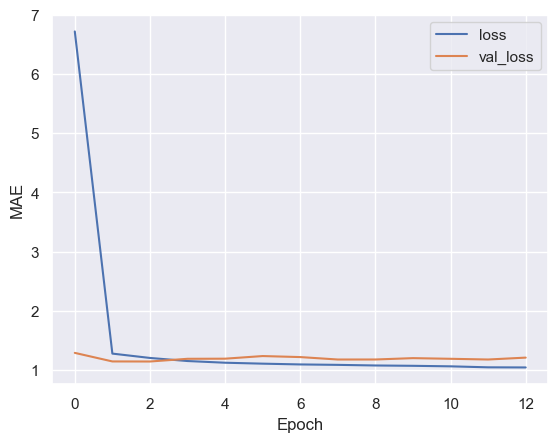

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step


In [86]:
all_scores = []

np.random.seed(101)
for train_index, test_index in list(kf.split(X_prac)):
    # Split the data
    X1_train, X1_test = X_prac_reset.iloc[train_index], X_prac_reset.iloc[test_index]
    y1_train, y1_test = y_prac_reset.iloc[train_index], y_prac_reset.iloc[test_index]

    # transforming the X sets using the preprocessor
    
    X1_train = pd.DataFrame(preprocessor.fit_transform(X1_train),columns=preprocessor.get_feature_names_out())
    X1_test = pd.DataFrame(preprocessor.transform(X1_test),columns=preprocessor.get_feature_names_out())

    #X1_train = preprocessor.fit_transform(X1_train)
    #X1_test = preprocessor.transform(X1_test)

    # building the model 
    np.random.seed(101)
    best_model1 = best_tuned_model()

    # fit the model 
    best_model1.fit(x=X1_train.values, y=y1_train, validation_data=(X1_test.values, y1_test),
              batch_size = 32, epochs = 58, verbose=0, callbacks=[early_stopping])

    # plotting the losses for better visualisation 
    loss1 = pd.DataFrame(best_model1.history.history)
    loss1[['loss','val_loss']].plot();
    plt.xlabel("Epoch"); 
    plt.ylabel("MAE");
    plt.show()
    
    #print(model1.history.history)

    # generating y_predictions for training and test set
    y1_preds_train = best_model1.predict(X1_train.values)
    y1_preds_test = best_model1.predict(X1_test.values)
    
    all_scores.append(metric_scores(y1_preds_train, y1_preds_test, y1_train, y1_test))

In [87]:
tuned_cv_scores = pd.DataFrame(all_scores, columns=["Train MAE","Train RMSE","Train R-squared",
                                    "Validation MAE","Validation RMSE","Validation R-squared"])
tuned_cv_scores

,Train MAE,Train RMSE,Train R-squared,Validation MAE,Validation RMSE,Validation R-squared
0,0.801118,1.017390,0.228547,0.832590,1.033107,0.097578
1,0.728051,0.915254,0.354098,0.813945,1.039767,0.205552
2,0.636884,0.816318,0.481914,0.789062,1.031809,0.243224
3,0.761894,0.978182,0.273362,0.830726,1.069379,0.109110
4,0.845898,1.064588,0.135616,0.863985,1.100024,0.075358


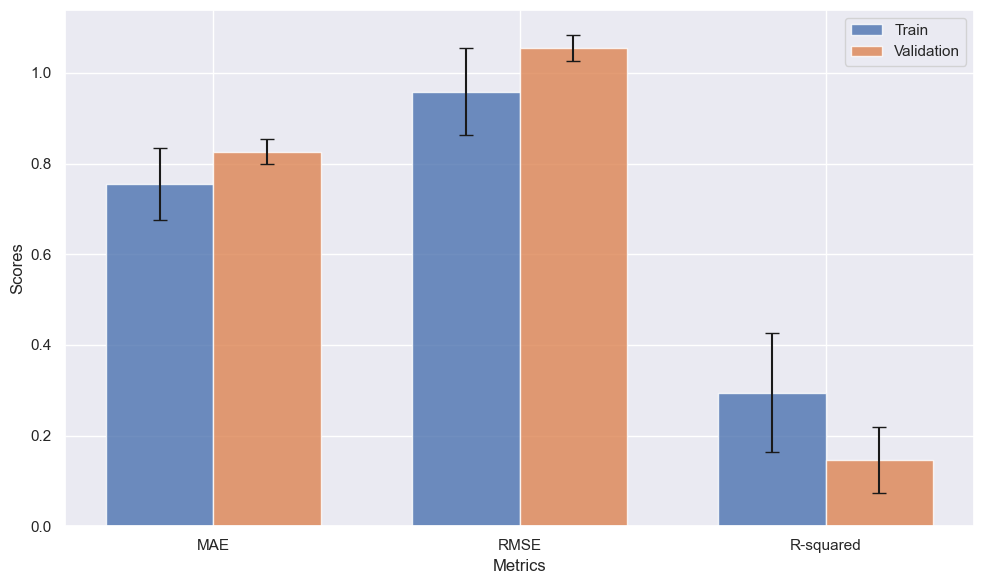

In [70]:
# plotting these scores together 
mean_scores = tuned_cv_scores.mean()
std_scores = tuned_cv_scores.std()

# Separate train and validation metrics
train_metrics = ['Train MAE', 'Train RMSE', 'Train R-squared']
val_metrics = ['Validation MAE', 'Validation RMSE', 'Validation R-squared']

# Prepare the plot
x_labels = ['MAE', 'RMSE', 'R-squared']
x = np.arange(len(x_labels))
width = 0.35  # Bar width

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Plot train scores
train_means = mean_scores[train_metrics]
train_stds = std_scores[train_metrics]
ax.bar(x - width/2, train_means, width, yerr=train_stds, capsize=5, label='Train', alpha=0.8)

# Plot validation scores
val_means = mean_scores[val_metrics]
val_stds = std_scores[val_metrics]
ax.bar(x + width/2, val_means, width, yerr=val_stds, capsize=5, label='Validation', alpha=0.8)

# Formatting
ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
#ax.set_title('Train vs Validation Scores with Error Bars', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

plt.tight_layout()
plt.show()


Base model mean CV scores: 
* Train MAE=0.705253; Val MAE=0.777586
* Train RMSE=0.902848; Val RMSE=0.995636	
* Train R^2=0.377928; Val R^2=0.240925

In [88]:
tuned_cv_scores.describe()

,Train MAE,Train RMSE,Train R-squared,Validation MAE,Validation RMSE,Validation R-squared
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.754769,0.958346,0.294707,0.826062,1.054817,0.146164
std,0.079237,0.096431,0.131069,0.027470,0.029508,0.073646
min,0.636884,0.816318,0.135616,0.789062,1.031809,0.075358
25%,0.728051,0.915254,0.228547,0.813945,1.033107,0.097578
50%,0.761894,0.978182,0.273362,0.830726,1.039767,0.109110
75%,0.801118,1.017390,0.354098,0.832590,1.069379,0.205552
max,0.845898,1.064588,0.481914,0.863985,1.100024,0.243224


Well, according to the mean CV scores, our previous model performed better instead of the tuned RS model. 

Finally, it is important that we report the final scores of our hold-out set for a confirmation on our basic Artificial Neural Network excercise.

In [89]:
# on our base model 
y_preds_train = model_es.predict(transformed_X_train_df.values)
y_preds_hold = model_es.predict(transformed_X_hold_df.values)

hold_scores = {}
hold_scores[f'Model_ES'] = metric_scores(y_preds_train, y_preds_hold,y_train,y_hold)

hold_scores_df = pd.DataFrame(data=hold_scores.values(), index=hold_scores.keys(),columns=["Train MAE","Train RMSE","Train R-squared",
                                                                                "Test MAE","Test RMSE","Test R-squared"])
hold_scores_df.index.name = 'Models'

hold_scores_df

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 438us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step


,Train MAE,Train RMSE,Train R-squared,Test MAE,Test RMSE,Test R-squared
Models,,,,,,
Model_ES,0.696508,0.90167,0.372005,0.794286,1.035677,0.214012


In [90]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 28)             │           924 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,921 (23.13 KB)

 Trainable params: 1,973 (7.71 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,948 (15.43 KB)

In [91]:
# on our tuned model 
y_preds_train = best_model.predict(transformed_X_train_df.values)
y_preds_hold = best_model.predict(transformed_X_hold_df.values)

hold_tuned_scores = {}
hold_tuned_scores[f'RS_Model_ES'] = metric_scores(y_preds_train, y_preds_hold,y_train,y_hold)

hold_tuned_scores_df = pd.DataFrame(data=hold_tuned_scores.values(), index=hold_tuned_scores.keys(),columns=["Train MAE","Train RMSE","Train R-squared",
                                                                                "Test MAE","Test RMSE","Test R-squared"])
hold_tuned_scores_df.index.name = 'Models'

hold_tuned_scores_df

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step


,Train MAE,Train RMSE,Train R-squared,Test MAE,Test RMSE,Test R-squared
Models,,,,,,
RS_Model_ES,0.652381,0.843605,0.450283,0.833539,1.062521,0.17274


In [92]:
# A comparison of the scores of our previous base model and a tuned model 

hold_combined_scores = pd.concat([hold_scores_df, hold_tuned_scores_df])
hold_combined_scores

,Train MAE,Train RMSE,Train R-squared,Test MAE,Test RMSE,Test R-squared
Models,,,,,,
Model_ES,0.696508,0.901670,0.372005,0.794286,1.035677,0.214012
RS_Model_ES,0.652381,0.843605,0.450283,0.833539,1.062521,0.172740



### Some concluding remarks about this project:

* Although we could move forward to perform an exhaustive grid search to optimise the search of hyperparameters, it is preferred that one move onto employing Graph Neural Networks in the prediction of pEC50.  
* At this stage, our best performing model is the original ANN model. 

### ML vs DL for this project. 
* **ML:** 
    * Achieved a **validation and test MAE of 0.60 and 0.63**, respectively, using a **tuned GradientBoosting regressor model** for pEC50 prediction for drugs binding to dopamine receptors.
    * Obtained resultsof MAE are in competitive ranges of 0.52 - 0.61 reported in scientific literature for this system. 
    * More details on the (portfolio page)[https://sites.google.com/view/bhawakshi-punia/pec50-prediction?authuser=0].
    * **Significant overfitting** observed in training stage while working with advanced models despite introducing early-stopping. 
* **DL:** 
    * Overfitting issue observed in machine learning approaches has been significantly reduced!
    * Using **feed-forward neural networks**, an artificial neural network was built to predict pEC50. 
    * Despite efforts to tune hyperparameters using keras_tuner, the ANN could predict pEC50 with an MAE of 0.79 which is appreciable but not an improvement from our gradient boosting model.


### Reasons to opt GNNs: 
* Small molecules can be mapped as nodes and edges to display them as graphs.
* This would offer a better visualisation and proper application of deep learning techniques in binding affinity prediction since these receptor-ligand binding events are sigificantly structurally mediated as well.
* Using GNNs will capture this structural effect, depending on individual molecules and their topology. This aspect was not possible to be appropriately captured in our machine learning and ANNs techniques. 